In [1]:
import pandas as pd
from neuralprophet import NeuralProphet
import matplotlib.pyplot as plt

In [4]:
data=pd.read_excel('C:/Users/USER/Desktop/진행중/FEMS/datamart/무림페이퍼_15분사용전력_210401-220630.xlsx')
data.columns
data=data.drop(['등록시각'],axis=1)

data['기준시각']=pd.to_datetime(data['기준시각'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   기준시각         42766 non-null  datetime64[ns]
 1   직전 15분 사용전력  42766 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 668.3 KB


ACF 확인

In [ ]:
def acf_plot(data, N_LAGS, pval):
    from statsmodels.graphics.tsaplots import plot_acf
    
    auto = pd.Series(data.values)
    for i in range(0, N_LAGS+1):
        print(f"lag at {i}'s autocorrelation = ", round(auto.autocorr(lag=i),2))
        scatter = pd.DataFrame()
        scatter['lags'] = [i for i in range (1, N_LAGS +1)]
        scatter['autocorrelation'] = [ auto.autocorr(lag=i) for i in range(1, N_LAGS +1)]

    fig = plot_acf(data, lags=N_LAGS, alpha=pval)
    plt.xlabel(f'Lag at k (0 to {N_LAGS})')
    plt.ylabel("lag at k's autocorrelation")
    plt.scatter(x=scatter['lags'], y=scatter['autocorrelation'], edgecolors='red',linewidth=1, s=200, alpha = .5)
    plt.show()

acf_plot(data['직전 15분 사용전력'].diff(1), 10, 0.05)
# acf_plot(data['직전 15분 사용전력'].diff(5), 30, 0.05)


feature 생성

In [61]:
#lag (Auto Regression) lag 1까지 생성
# data['l_1'] = data['직전 15분 사용전력'].shift(1)
data['l_2']= data['직전 15분 사용전력'].shift(2)
# data['l_3']= data['직전 15분 사용전력'].shift(3)
# data['l_4']= data['직전 15분 사용전력'].shift(4)
# data['l_5']= data['직전 15분 사용전력'].shift(5)
# data['l_6']= data['직전 15분 사용전력'].shift(6)
# data['l_7']= data['직전 15분 사용전력'].shift(7)
# data['l_8']= data['직전 15분 사용전력'].shift(8)
# data['l_9']= data['직전 15분 사용전력'].shift(9)
# data['l_10']= data['직전 15분 사용전력'].shift(10)

WARNING - (py.warnings._showwarnmsg) - C:\Users\USER\AppData\Local\Temp\ipykernel_16760\342044880.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




In [62]:
#diff 1 차분(직전, 직직전의 차이)
data['d_2']=data['직전 15분 사용전력'].diff(1).shift(1)


WARNING - (py.warnings._showwarnmsg) - C:\Users\USER\AppData\Local\Temp\ipykernel_16760\1583698968.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




In [63]:
data

,기준시각,직전 15분 사용전력,d_2,l_2
2,2021-04-01 00:30:00,7442.4,NaN,NaN
3,2021-04-01 00:45:00,7392.0,NaN,NaN
4,2021-04-01 01:00:00,7576.8,-50.4,7442.4
5,2021-04-01 01:15:00,7492.8,184.8,7392.0
6,2021-04-01 01:30:00,7660.8,-84.0,7576.8
...,...,...,...,...
42761,2022-06-30 22:45:00,5628.0,50.4,5594.4
42762,2022-06-30 23:00:00,5560.8,-16.8,5644.8
42763,2022-06-30 23:15:00,5493.6,-67.2,5628.0
42764,2022-06-30 23:30:00,5527.2,-67.2,5560.8


In [64]:
# 결측 보강(interplation)
# data=data.fillna(method='bfill')
data=data.dropna()
data

,기준시각,직전 15분 사용전력,d_2,l_2
4,2021-04-01 01:00:00,7576.8,-50.4,7442.4
5,2021-04-01 01:15:00,7492.8,184.8,7392.0
6,2021-04-01 01:30:00,7660.8,-84.0,7576.8
7,2021-04-01 01:45:00,7677.6,168.0,7492.8
8,2021-04-01 02:00:00,7610.4,16.8,7660.8
...,...,...,...,...
42761,2022-06-30 22:45:00,5628.0,50.4,5594.4
42762,2022-06-30 23:00:00,5560.8,-16.8,5644.8
42763,2022-06-30 23:15:00,5493.6,-67.2,5628.0
42764,2022-06-30 23:30:00,5527.2,-67.2,5560.8


In [110]:
#train_test split
def train_test_split(data_t,train_cut_date,val_cut_date): 
  
    df_train = data_t[data_t['기준시각'] < train_cut_date ]
    df_val= data_t[(data_t['기준시각'] >= train_cut_date ) & (data_t['기준시각'] < val_cut_date )]
    df_test = data_t[(data_t['기준시각'] >= val_cut_date)] 
    
    return (df_train,df_val,df_test) 

df_train,df_val,df_test=train_test_split(data,'2022-05-30','2022-06-30 23:15:00')
print('train_df=',min(df_train['기준시각']),'~',max(df_train['기준시각']),',',len(df_train))
print('val_df=',min(df_val['기준시각']),'~',max(df_val['기준시각']),',',len(df_val))
print('test_df=',min(df_test['기준시각']),'~',max(df_test['기준시각']),',',len(df_test))


train_df= 2021-04-01 01:00:00 ~ 2022-05-29 23:45:00 , 39690
val_df= 2022-05-30 00:00:00 ~ 2022-06-30 23:00:00 , 3069
test_df= 2022-06-30 23:15:00 ~ 2022-06-30 23:45:00 , 3


In [111]:
df_train.rename(columns={"기준시각": "ds", "직전 15분 사용전력": "y"}, inplace=True)
df_val.rename(columns={"기준시각": "ds", "직전 15분 사용전력": "y"}, inplace=True)
df_test.rename(columns={"기준시각": "ds", "직전 15분 사용전력": "y"}, inplace=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\USER\AppData\Local\Temp\ipykernel_16760\3057321360.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


WARNING - (py.warnings._showwarnmsg) - C:\Users\USER\AppData\Local\Temp\ipykernel_16760\3057321360.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


WARNING - (py.warnings._showwarnmsg) - C:\Users\USER\AppData\Local\Temp\ipykernel_16760\3057321360.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [119]:
model_tune = NeuralProphet(
n_lags=2,
n_forecasts=3,
num_hidden_layers=2,
# changepoints_range=0.95,
# n_changepoints=5,
# learning_rate=0.1
)

model_tune = model_tune.add_lagged_regressor(names='l_2',normalize='minmax')
model_tune = model_tune.add_future_regressor(name='d_2',normalize='minmax')   #regularization=0.05
# model_tune = model_tune.add_future_regressor(name='l_2',normalize='minmax')
# model_tune = model_tune.add_future_regressor(name='l_3',normalize='minmax')
# model_tune = model_tune.add_future_regressor(name='l_4',normalize='minmax')
# model_tune = model_tune.add_future_regressor(name='l_5',normalize='minmax')
# model_tune = model_tune.add_future_regressor(name='l_6',normalize='minmax')
# model_tune = model_tune.add_future_regressor(name='l_7',normalize='minmax')
# model_tune = model_tune.add_future_regressor(name='l_8',normalize='minmax')
# model_tune = model_tune.add_future_regressor(name='l_9',normalize='minmax')
# model_tune = model_tune.add_future_regressor(name='l_10',normalize='minmax')

In [137]:
# from locale import normalize


# model=NeuralProphet(n_lag=7)
# model = model.add_future_regressor(name='l_1',normalize='minmax')
# model = model.add_future_regressor(name='l_2',normalize='minmax')
# model = model.add_future_regressor(name='l_3',normalize='minmax')
# model = model.add_future_regressor(name='l_4',normalize='minmax')
# model = model.add_future_regressor(name='l_5',normalize='minmax')
# model = model.add_future_regressor(name='l_6',normalize='minmax')
# model = model.add_future_regressor(name='l_7',normalize='minmax')

In [ ]:
#학습데이터, 검증데이터 분리
# train, val = model_tune.split_df(df_train, valid_p = 0.1)

# print(len(train),len(val))


In [118]:
from enum import auto


metrics = model_tune.fit(df_train,validation_df=df_val, progress='plot')    #

INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.982% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as 15T
INFO - (NP.forecaster.__handle_missing_data) - 1010 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 85 NaN values in column y were auto-imputed.


ValueError: More than 30 consecutive missing values encountered in column y. 925 NA remain. Please preprocess data manually.

In [83]:
metrics

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
0,0.511555,6684.274338,8565.709431,0.0,0.063669,2224.163003,2760.378734
1,0.030189,1359.818121,1816.214248,0.0,0.010411,883.112046,1106.279167
2,0.011109,714.423231,1126.633835,0.0,0.005807,635.841194,827.436927
3,0.005531,533.366900,793.820375,0.0,0.002309,360.629106,522.234828
4,0.002049,345.117094,482.418100,0.0,0.001168,252.333922,368.873388
...,...,...,...,...,...,...,...
67,0.000163,97.457754,134.664882,0.0,0.000152,96.353914,133.765511
68,0.000159,95.881099,132.983019,0.0,0.000138,89.379887,127.160620
69,0.000154,93.546657,130.738366,0.0,0.000137,89.299726,126.889455
70,0.000152,92.380631,129.589321,0.0,0.000135,88.482940,126.062712


In [84]:
#metric 확인
print("SmoothL1Loss: ", metrics.SmoothL1Loss.tail(1).item())
print("MAE(Train): ", metrics.MAE.tail(1).item())
print("MAE(val): ", metrics.MAE_val.tail(1).item())

SmoothL1Loss:  0.00014985502082742904
MAE(Train):  91.60163624024145
MAE(val):  88.28822148417214


In [85]:
#loss 그래프
import plotly.express as px
px.line(metrics, y=['MAE', 'MAE_val'], width=800, height=400)

In [86]:
# df_test=df_test.drop(['y'],axis=1)

df_test

,ds,y,d_2,l_2
42763,2022-06-30 23:15:00,5493.6,-67.2,5628.0
42764,2022-06-30 23:30:00,5527.2,-67.2,5560.8
42765,2022-06-30 23:45:00,5670.0,33.6,5493.6


In [97]:
# fig, ax = plt.subplots(figsize=(14, 10)) 
forecast = model_tune.predict(df_test)
# fig=model.plot(forecast[['ds','y','yhat1']])


fig, ax = plt.subplots(figsize=(14, 10)) 
model_tune= model_tune.highlight_nth_step_ahead_of_each_forecast(model.n_forecasts)
model_tune.plot(forecast, xlabel="Date", ylabel="Temp", ax=ax)
ax.set_title("moorim_demand", fontsize=28, fontweight="bold")

ValueError: Model has not been fitted. Predictions will be random.

In [88]:
forecast

,ds,y,yhat1,residual1,trend,season_weekly,season_daily,future_regressors_additive,future_regressor_d_2,future_regressor_l_2
0,2022-06-30 23:15:00,5493.6,5575.293457,81.693457,-5188.729980,9.892281,2.077462,10752.053711,5742.973145,5009.079590
1,2022-06-30 23:30:00,5527.2,5508.571777,-18.628223,-5188.729980,10.072044,1.742917,10685.487305,5742.973145,4942.513672
2,2022-06-30 23:45:00,5670.0,5555.656250,-114.343750,-5188.730469,10.248831,0.739714,10733.398438,5857.451172,4875.947754


In [321]:
import numpy as np
def SMAPE(y_true, y_pred):
    return np.mean( (np.abs(y_true-y_pred)) / ((np.abs(y_true) + np.abs(y_pred))/2) ) * 100
SMAPE(forecast['y'],forecast['yhat1'])

0.0011988045955239684

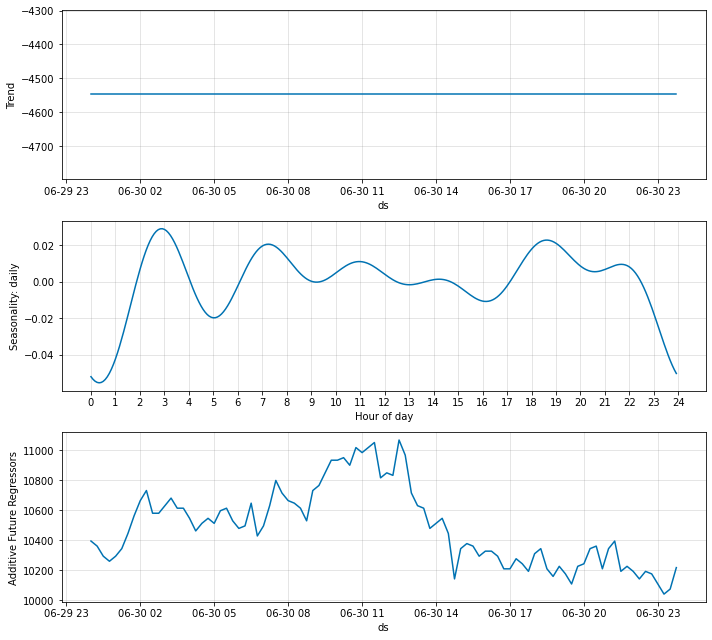

In [322]:
fig_comp = model_tune.plot_components(forecast)

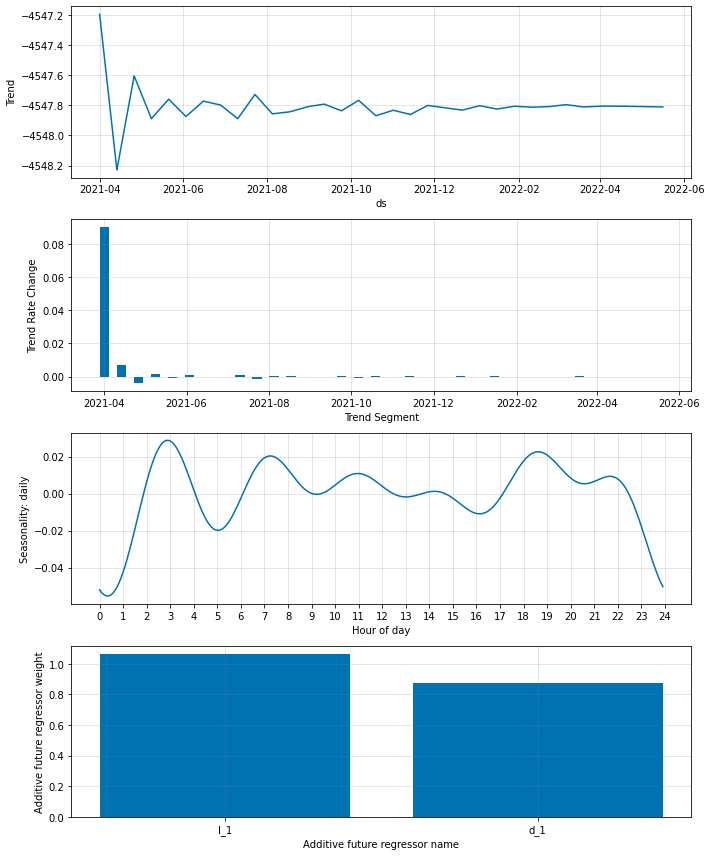

In [323]:
fig_param = model_tune.plot_parameters()

In [183]:
# future = model.make_future_dataframe(df_test, periods=len(df_test), n_historic_predictions=len(df_test)) 
# forecast = model.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 15T


ValueError: Future values of all user specified regressors not provided

### daily average


In [99]:
data=pd.read_csv('C:/Users/USER/Desktop/진행중/FEMS/datamart/(하루평균)무림페이퍼_15분사용전력_210401-220630.csv')
data=data[['date','평균(직전 15분 사용전력)']]

data['date']=pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             447 non-null    datetime64[ns]
 1   평균(직전 15분 사용전력)  447 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.1 KB


In [103]:
#train_test split
def train_test_split(data_t,train_cut_date,val_cut_date): 
  
    df_train = data_t[data_t['date'] < train_cut_date ]
    # df_val= data_t[(data_t['date'] >= train_cut_date ) & (data_t['기준시각'] < val_cut_date )]
    df_test = data_t[(data_t['date'] >= val_cut_date)] 
    
    return (df_train,df_val,df_test) 

df_train,df_val,df_test=train_test_split(data,'2022-05-25','2022-05-25')
print('train_df=',min(df_train['date']),'~',max(df_train['date']),',',len(df_train))
# print('val_df=',min(df_val['기준시각']),'~',max(df_val['기준시각']),',',len(df_val))
print('test_df=',min(df_test['date']),'~',max(df_test['date']),',',len(df_test))

train_df= 2021-04-01 00:00:00 ~ 2022-05-24 00:00:00 , 410
test_df= 2022-05-25 00:00:00 ~ 2022-06-30 00:00:00 , 37


In [104]:

df_train.rename(columns={"date": "ds", "평균(직전 15분 사용전력)": "y"}, inplace=True)
df_test.rename(columns={"date": "ds", "평균(직전 15분 사용전력)": "y"}, inplace=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\USER\AppData\Local\Temp\ipykernel_13212\3068202567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.rename(columns={"date": "ds", "평균(직전 15분 사용전력)": "y"}, inplace=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\USER\AppData\Local\Temp\ipykernel_13212\3068202567.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.rename(columns={"date": "ds", "평균(직전 15분 사용전력)": "y"}, inplace=True)



In [141]:
future = m.make_future_dataframe(df_test, periods=len(df_test), n_historic_predictions=len(df_test)) 
forecast = m.predict(future)
forecast

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.297% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.649% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.649% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning:

The fram

,ds,y,yhat1,residual1,trend
0,2022-05-25,7864.675,6834.283203,-1030.391797,6834.283203
1,2022-05-26,7697.2,6834.283203,-862.916797,6834.283203
2,2022-05-27,7769.825,6834.283203,-935.541797,6834.283203
3,2022-05-28,7064.8375,6834.283203,-230.554297,6834.283203
4,2022-05-29,5390.0875,6834.283203,1444.195703,6834.283203
...,...,...,...,...,...
69,2022-08-02,None,6834.283203,NaN,6834.283203
70,2022-08-03,None,6834.283203,NaN,6834.283203
71,2022-08-04,None,6834.283203,NaN,6834.283203
72,2022-08-05,None,6834.283203,NaN,6834.283203


Text(0.5, 1.0, 'demand')

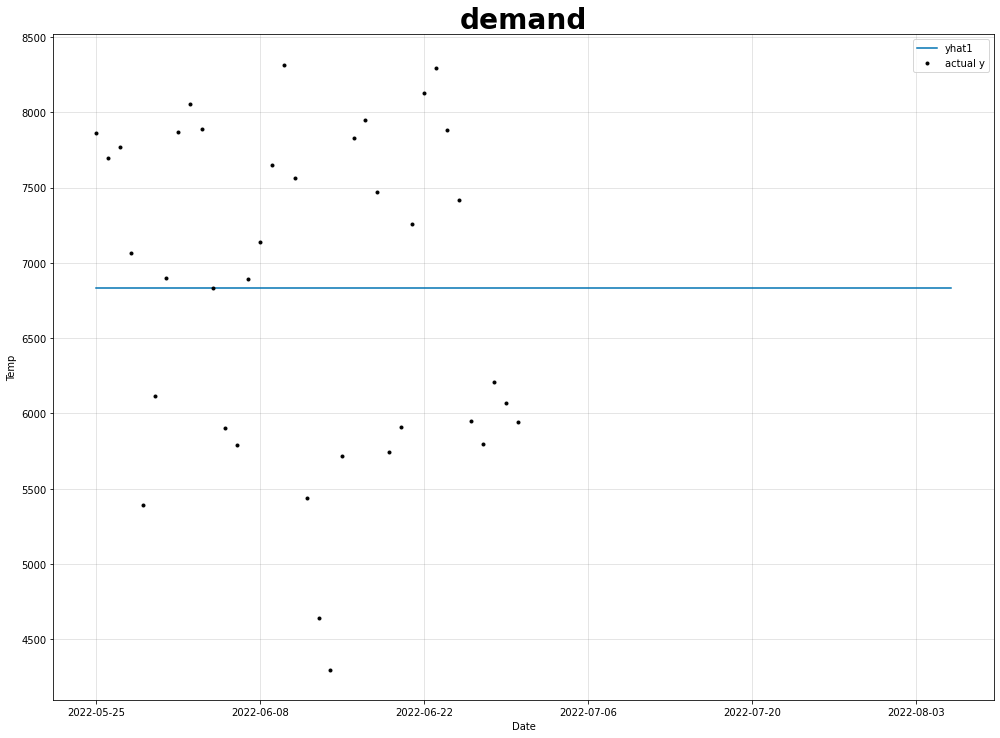

In [142]:
fig, ax = plt.subplots(figsize=(14, 10)) 
m.plot(forecast, xlabel="Date", ylabel="Temp", ax=ax)
ax.set_title("demand", fontsize=28, fontweight="bold")